## До-обучение модели Stable Diffusion XL

В этом примере мы до-обучаем [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) по технологии [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) и [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora).

## Начальная настройка

Для начала, установим необходимые библиотеки. Это нужно сделать один раз в проекте Datasphere. Для работы скриптов надо обновить используемые версии библиотеки pytorch.

In [ ]:
%pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [10]:
# Install dependencies.
%pip install bitsandbytes transformers accelerate peft datasets shwarsutils

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for shwarsutils: filename=shwarsutils-0.0.1-py3-none-any.whl size=3622 sha256=df2b81d28f394a3e4b9934bae509acd8582450286b6a674af0f377cf1e825db4
  Stored in directory: /tmp/xdg_cache/pip/wheels/c4/fd/b1/f562dff2b9ef92f90ebbc2d3ec52756e7bdeb20abe32b7b103
Successfully built shwarsutils

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Также установим определённую версию библиотеки `diffusers`:

In [6]:
%pip install git+https://github.com/huggingface/diffusers.git@b88fef47851059ce32f161d17f00cd16d94af96a

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/diffusers.git (to revision b88fef47851059ce32f161d17f00cd16d94af96a) to /tmp/pip-req-build-5o_g8ukt
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-5o_g8ukt
  Running command git rev-parse -q --verify 'sha^b88fef47851059ce32f161d17f00cd16d94af96a'
  Running command git fetch -q https://github.com/huggingface/diffusers.git b88fef47851059ce32f161d17f00cd16d94af96a
  Resolved https://github.com/huggingface/diffusers.git to commit b88fef47851059ce32f161d17f00cd16d94af96a
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


### Датасет

Датасет в виде набора исходных изображений нужно куда-то поместить:
* Загрузить в текущую директорую Datasphere
* Загрузить в хранилище S3 и настроить S3-коннектор

В любом случае путь к данным нужно поместить в переменную ниже:

In [2]:
data_path = "/home/jupyter/datasphere/s3/mystor/gerbarium" 
images = f"{data_path}/*.jpg"

Посмотрим на картинки:

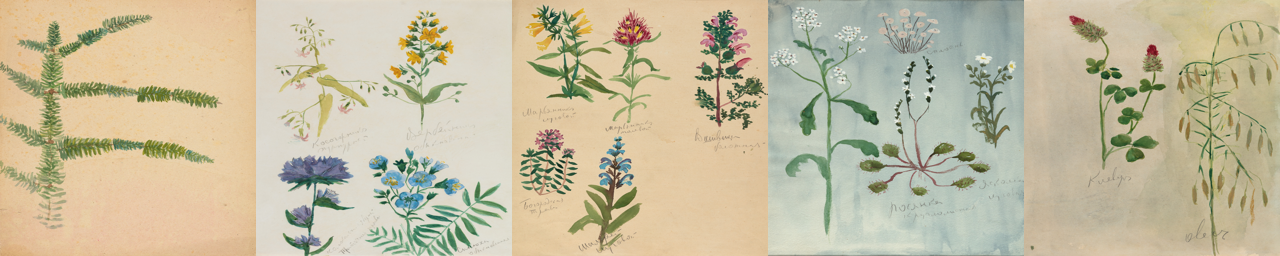

In [2]:
from PIL import Image
import glob

def image_grid(imgs, rows, cols, resize=256):
    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

imgs = [Image.open(path) for path in glob.glob(images)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Сгенерируем промпты с помощью BLIP

Для обучения модели нам полезно использовать для каждой картинки промпт, который отражает её содержание. Для автоматического получения таких промптов используем нейросеть BLIP:

In [5]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

**ВАЖНО!**

Теперь нужно определиться с идентификатором TOK нашего стиля или объекта:
- Для стилей используйте "In the style of TOK"
- Для людей - "photo of a TOK person"
- Можно использовать дополнительные слова, которые подталкивают модель к нужным смысла, например вместо "a photo of TOK" можно использовать "a photo of TOK dog" / "a photo of TOK corgi dog"

Можете использовать префикс или суффикс в зависимости от особенностей запроса.

In [16]:
import json

caption_prefix = ""
caption_suffix = ", gerbarium in GRBX style"

imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(images)]

with open(f'{data_path}/metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0] + caption_suffix
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

В итоге все сгенерированные промпты записались в файл `metadata.jsonl` в директории с данными.

In [17]:
with open(f'{data_path}/metadata.jsonl') as f:
    print(f.read())

{"file_name": "mgr_10_web.jpg", "prompt": "a painting of a fern leaf on a beige background, gerbarium in GRBX style"}
{"file_name": "mgr_111_web.jpg", "prompt": "four flowers, one with a green stem and one with a yellow stem, gerbarium in GRBX style"}
{"file_name": "mgr_112_web.jpg", "prompt": "a drawing of flowers on a piece of paper, gerbarium in GRBX style"}
{"file_name": "mgr_113_web.jpg", "prompt": "a painting of flowers and leaves on a blue background, gerbarium in GRBX style"}
{"file_name": "mgr_114_web.jpg", "prompt": "a painting of a flower and a plant, gerbarium in GRBX style"}
{"file_name": "mgr_11_web.jpg", "prompt": "a drawing of a plant with leaves on it, gerbarium in GRBX style"}
{"file_name": "mgr_12_web.jpg", "prompt": "a drawing of a branch with yellow flowers, gerbarium in GRBX style"}
{"file_name": "mgr_13_web.jpg", "prompt": "a pine tree branch with needles and needles, gerbarium in GRBX style"}
{"file_name": "mgr_14_web.jpg", "prompt": "a drawing of a plant with y

Освободим память GPU от использованных моделей:

In [6]:
import gc

del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Обучение!

> Если вы хотите обучать модель с одним промптом с использованием `instance_prompt`, то
укажите параметр `instance_data_dir` вместо `dataset_name`

Важные параметры:
 - `output_dir` показывает директорию (и имя репозитория) для обученной LoRA-модели
 - `caption_column` указывает название поля с промптом в нашем датасете. Если вы сгенерировали промпты с помощью кода выше, то используем "prompt"
 
Чтобы использовать поменьше памяти GPU и ускорить обучение, используем следующие приёмы:
* Gradient checkpointing (--gradient_accumulation_steps)
* 8-bit Adam (--use_8bit_adam)
* Mixed-precision training (--mixed-precision="fp16")

In [3]:
model_name = "./GRBX_LoRA"
instance_prompt = "gerbarium in GRBX style"

In [ ]:
from train_dreambooth_lora_sdxl import main

class dotdict(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

args = dotdict({})

args.pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0"
args.pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix"
args.dataset_name=data_path
args.output_dir=model_name
args.caption_column="prompt"
args.mixed_precision="fp16"
args.instance_prompt=instance_prompt
args.resolution_h=768
args.resolution_w=512
args.train_batch_size=2
args.gradient_accumulation_steps=3
args.gradient_checkpointing=True
args.learning_rate=1e-4
args.snr_gamma=5.0
args.lr_scheduler="constant"
args.lr_warmup_steps=0
args.mixed_precision="fp16"
args.use_8bit_adam=True
args.max_train_steps=500
args.checkpointing_steps=250
args.seed=0
args.logging_dir="logs"
args.revision="main"
args.rank=4
args.use_dora=False
args.optimizer="AdamW"
args.adam_beta1=0.9
args.adam_beta2=0.999
args.adam_epsilon=1e-08
args.adam_weight_decay=1e-04
args.repeats=1
args.num_validation_images=4
args.validation_epochs=50
args.center_crop=False
args.text_encoder_lr=5e-6
args.max_grad_norm=1.0
args.dataloader_num_workers=0

main(args)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-11 15:23:57.343517: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 15:23:57.395878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 15:23:59.094917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
03/11/2025 15:24:04 - INFO - t

[0;31mKernelOutOfMemory[0m: Kernel ran out of memory and has been restarted. If the restart fails, restart the kernel from the Kernel menu.
If the error persists, try choosing a different configuration or optimizing your code.

Натренированные файлы LoRA-модели находятся в директории `model_name`. Там находятся с одной стороны финальный результат обучения, а также промежуточные *чекпоинты*.

In [7]:
import glob

glob.glob(model_name+"/*")

['./GRBX_LoRA/checkpoint-250',
 './GRBX_LoRA/checkpoint-500',
 './GRBX_LoRA/pytorch_lora_weights.safetensors']

## Применяем модель

Попробуем сгенерировать изображения с помощью нашей модели. 

> На всякий случай, чтобы очистить память, в этом месте можно перезапустить Notebook Kernel.

Для начала, загружаем модель:

In [21]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
pipe = None
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(model_name)
_ = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Теперь собственно приступаем к генерации изображения:

100%|██████████| 25/25 [00:21<00:00,  1.19it/s]


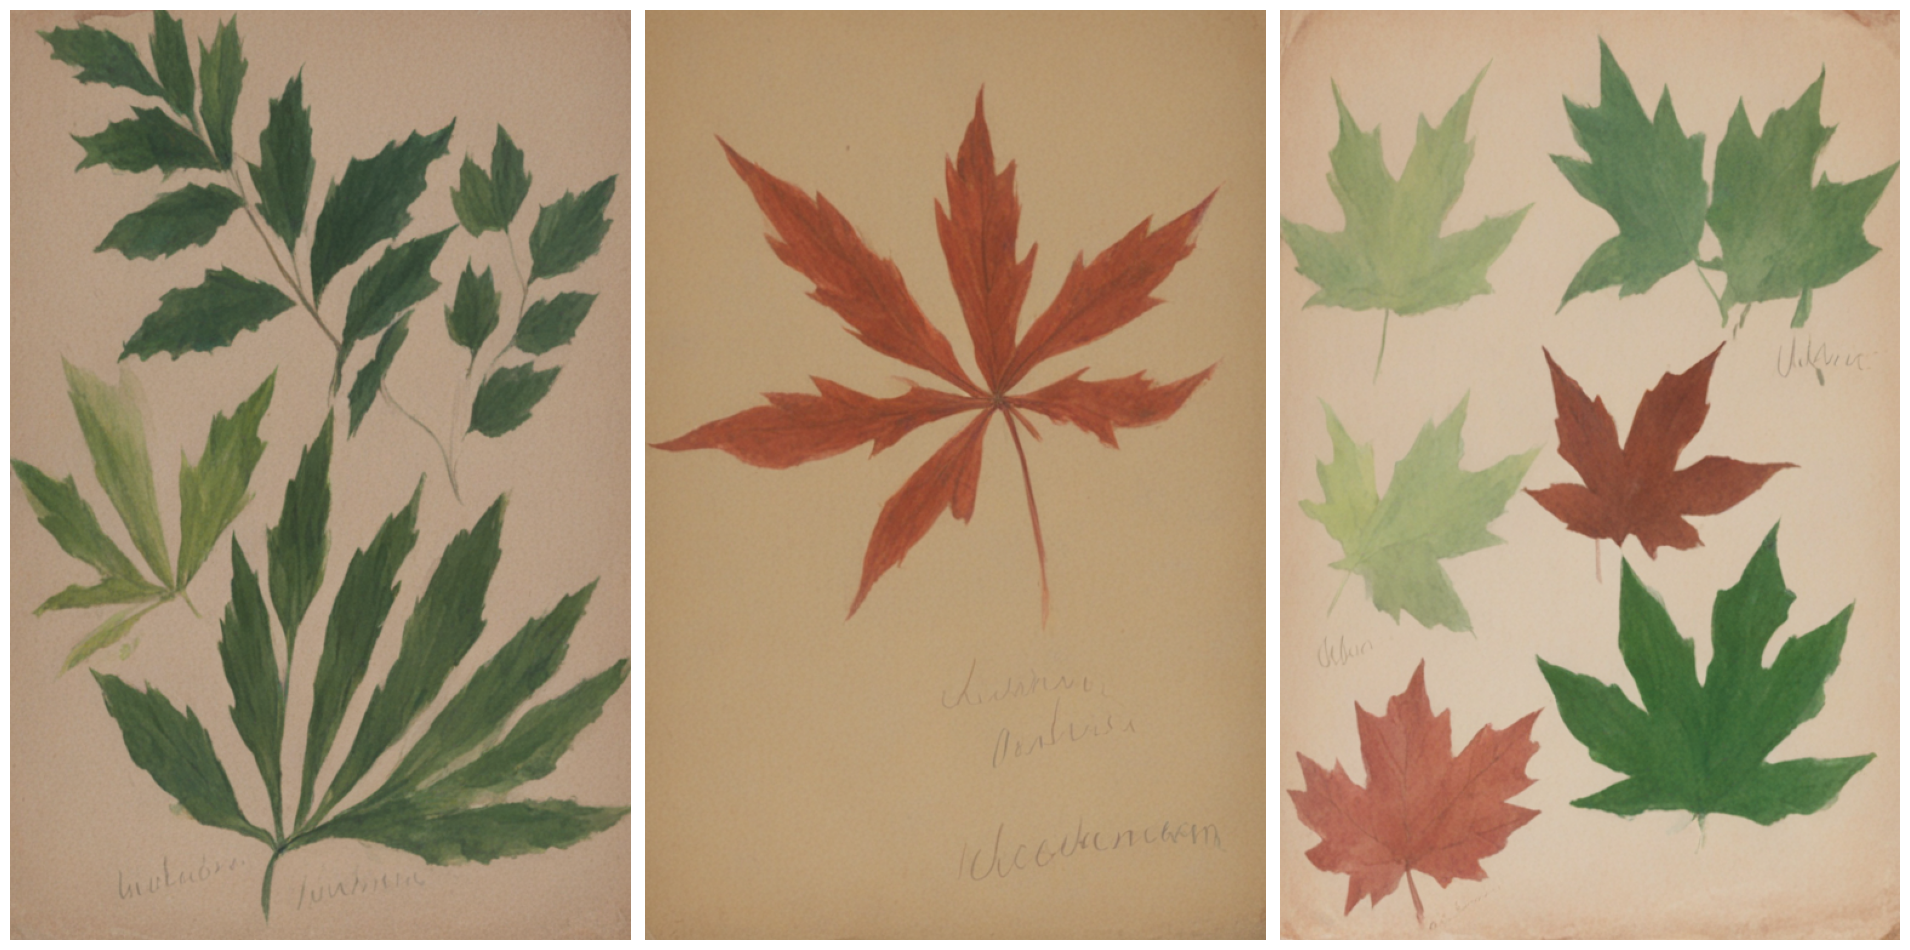

In [13]:
from shwars.utils import display_images

prompt = "maple leaf, gerbarium in GRBX style"

images = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt=3, height=768, width=512).images
display_images(images)

Генерируем серию из изображений:

In [23]:
import os

plant_names = [
    "Meadow vetchling",
    "Bamboo",
    "Common dogwood",
    "Thistle",
    "Geranium",
    "Meadow cow-wheat",
    "Field cow-wheat",
    "Marsh lousewort",
    "Creeping thyme",
    "Meadow sage",
    "Poppy 'Danish Flag'",
    "Splachnum",
    "Round-leaved sundew",
    "Meadow chickweed",
    "Spindle tree",
    "Laurel",
    "Boxwood",
    "Common Jacob's-ladder",
    "Common comfrey",
    "Broomrape",
    "Purple foxglove",
    "Globe-thistle",
    "Purple milkvetch",
    "Common loosestrife",
    "Clustered bellflower",
    "Common Jacob's-ladder",
    "Crimean pine",
    "Lungwort",
    "White sweet clover",
    "Common arrowhead",
    "Feverfew",
    "Dogwood",
    "Field scabious",
    "Common water plantain",
    "Cat's foot",
    "Common ragwort",
    "Fine-leaved ragwort",
    "Poisonous lettuce",
    "Arnica",
    "Ground-ivy",
    "Pheasant's eye (Adonis flame)",
    "Apricot",
    "Plum",
    "Cypress",
    "Periwinkle",
    "Red clover",
    "Oats",
    "Mallow",
    "Chamomile",
    "Dyer's saw-wort",
    "Forest bellflower",
    "Wood avens",
    "Spring/wood pea",
    "Field bindweed",
    "Fern",
    "Common lady's mantle",
    "Goat's-beard",
    "Cornflower",
    "Sainfoin",
    "Coltsfoot",
    "Bleeding heart",
    "Field carnation",
    "White campion",
    "Nasturtium",
    "Fireweed (Ivan tea)",
    "Lady's slipper orchid",
    "Wood mallow",
    "Mahonia",
    "Larkspur",
    "Nasturtium"
]

os.makedirs('output',exist_ok=True)
for x in plant_names:
    prompt = f"drawing of {x} plant on white background, gerbarium in GRBX style"
    fn = x.replace('/','_').replace('\'','').replace('(','').replace(')','')
    images = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt=3, 
                  height=768, width=512,verbose=0).images
    for i,im in enumerate(images):
        im.save(f"output/{fn}_{i}.jpg")

100%|██████████| 25/25 [00:22<00:00,  1.12it/s]


Попробуем загрузить промежуточный чекпоинт:

In [14]:
pipe = None

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(model_name+"/checkpoint-250")
_ = pipe.to("cuda")

Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


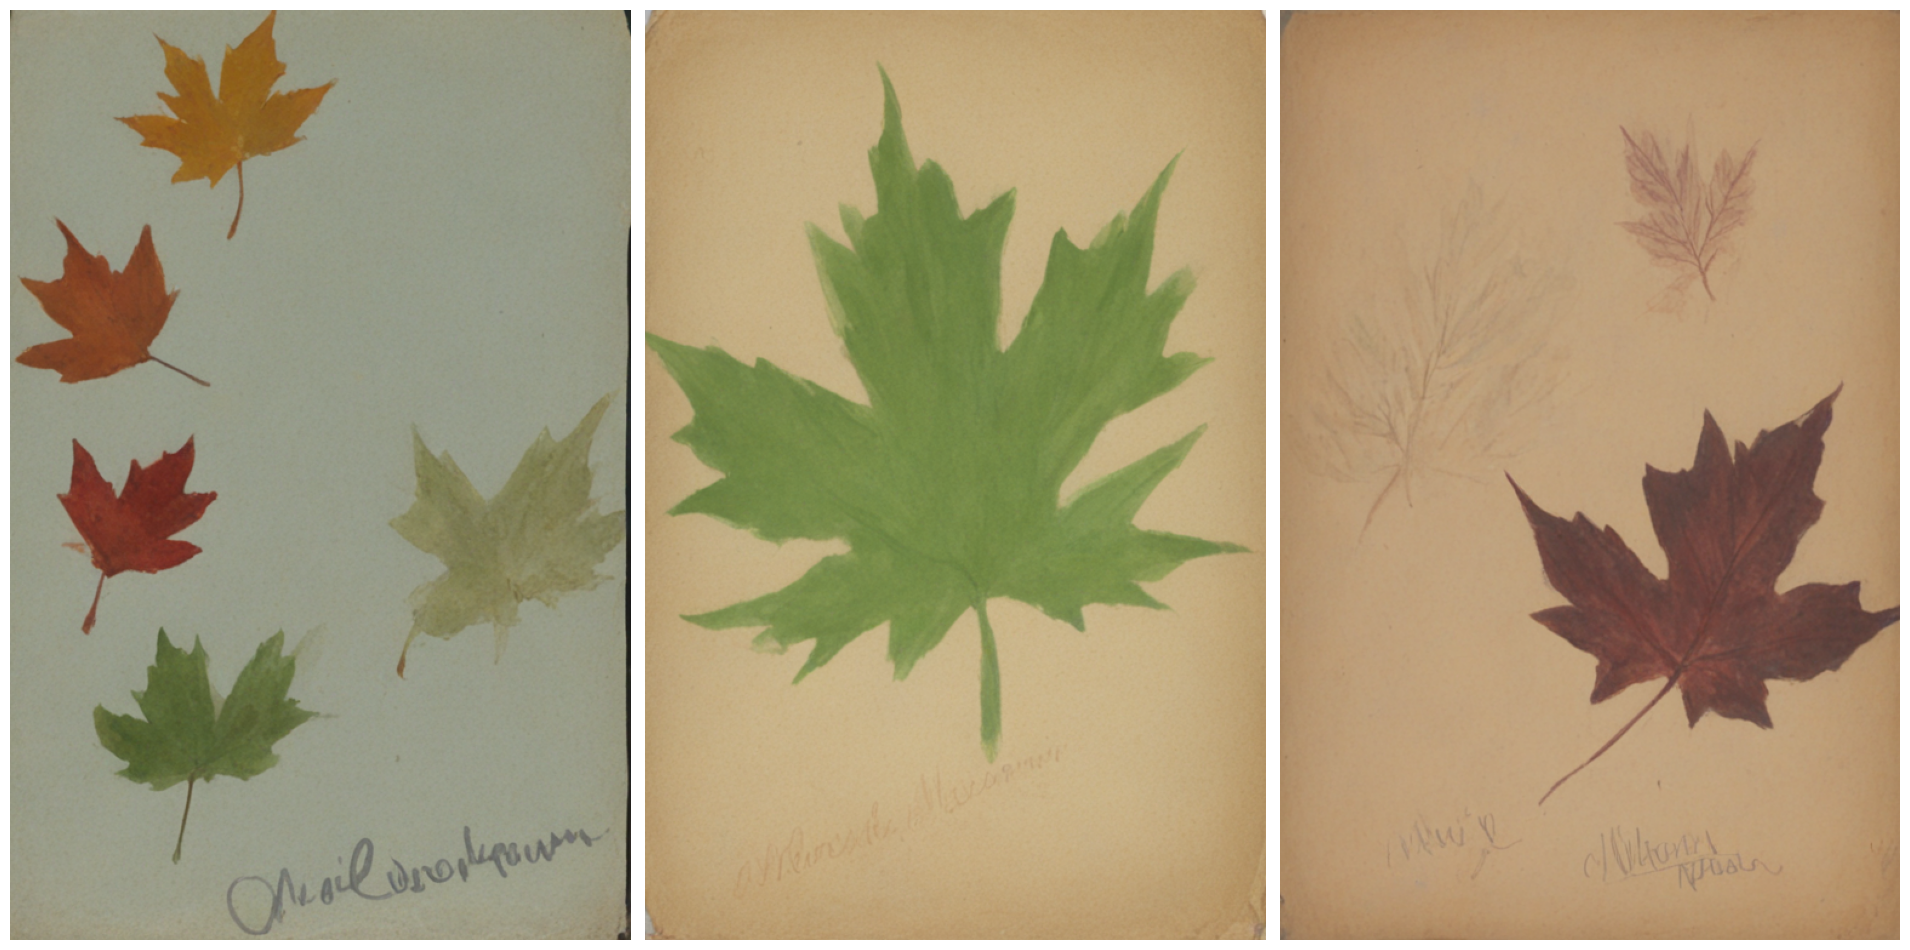

In [15]:
prompt = "maple leaf, gerbarium in GRBX style"

images = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt=3, height=768, width=512).images
display_images(images)

Попробуем применить LoRA-стиль не в полную силу:

In [16]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

pipe = None

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(model_name)
pipe.fuse_lora(lora_scale=0.5)
_ = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


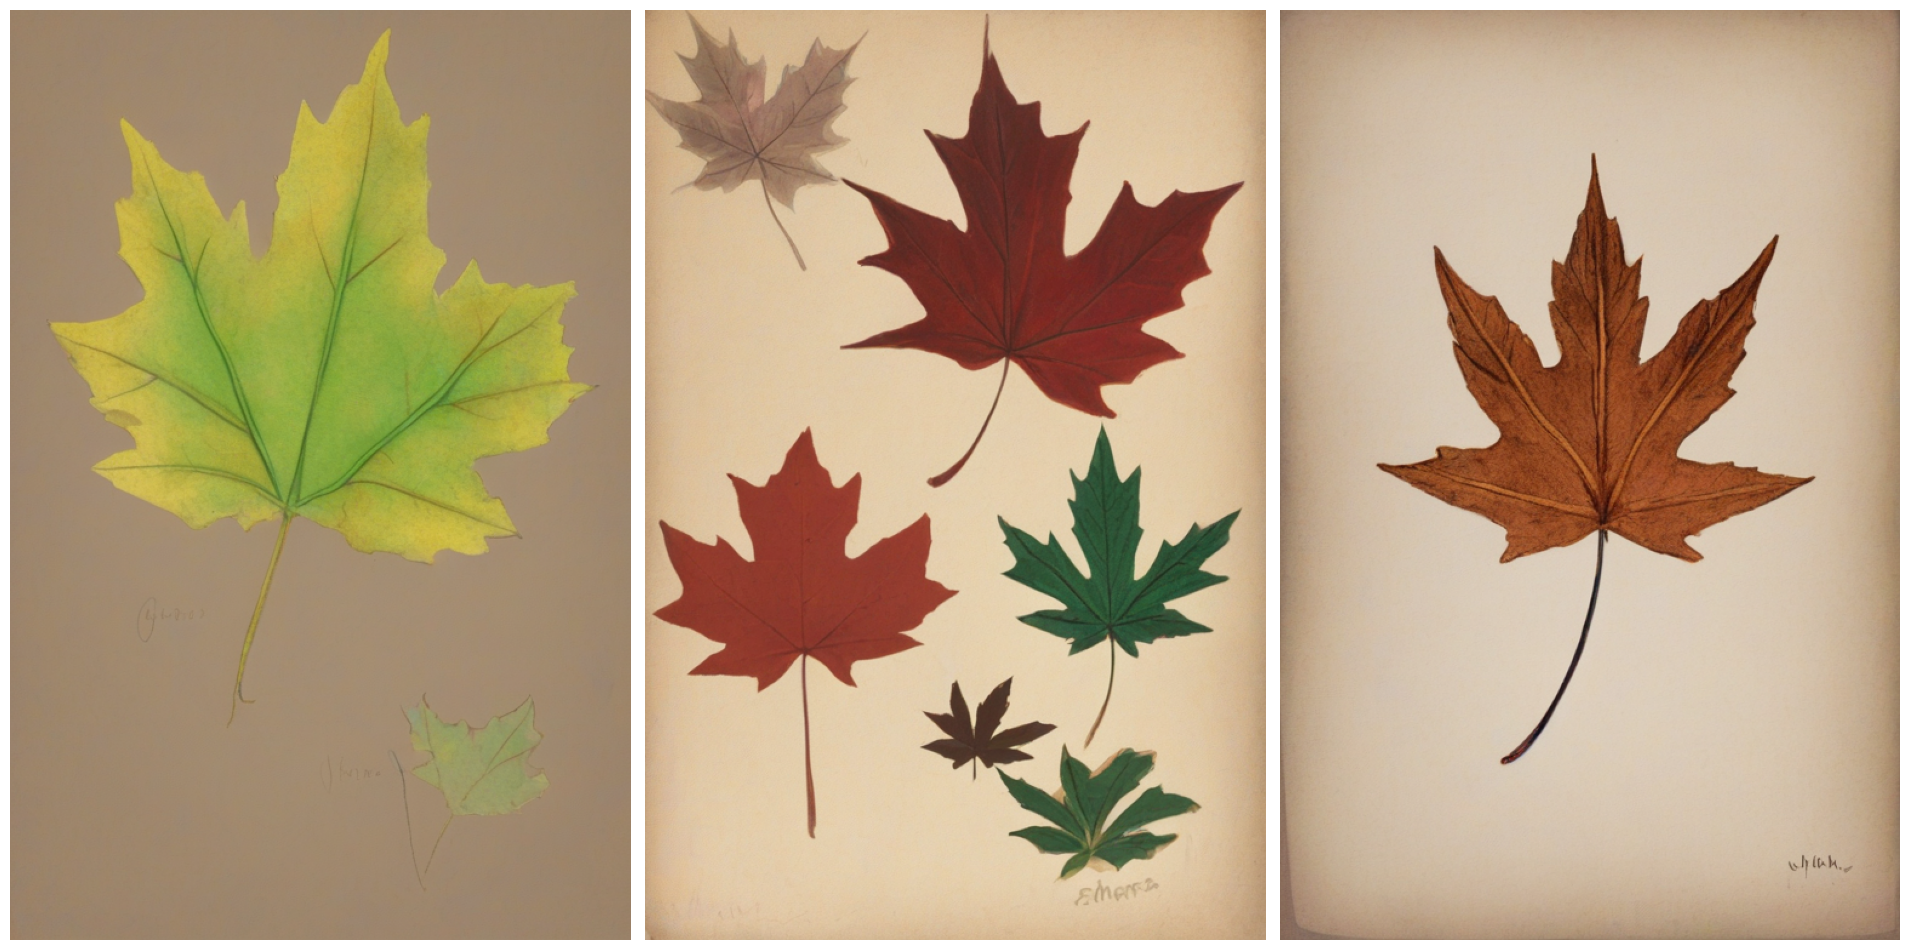

In [17]:
prompt = "maple leaf, gerbarium in GRBX style"

images = pipe(prompt=prompt, num_inference_steps=25, num_images_per_prompt=3, height=768, width=512).images
display_images(images)

## Сохраняем модель на HuggingFace

Ячейки в этом разделе выполняйте только в том случае, если вы хотите сохранить свою модель в репозитории HuggingFace. Для этого сначала надо войти в HuggingFace, указав **токен** с правами на запись.

In [18]:
from huggingface_hub import notebook_login
notebook_login()

In [19]:
from huggingface_hub import whoami
from pathlib import Path

short_model_name = model_name[model_name.find('/')+1:] if '/' in model_name else model_name

username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{short_model_name}"
print(f"Using repo id {repo_id}")

Using repo id shwars/GRBX_LoRA


In [20]:
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt=instance_prompt,
    validation_prompt=None,
    repo_folder=short_model_name,
    use_dora = False,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=model_name,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]
Upload 11 LFS files:   0%|          | 0/11 [00:00<?, ?it/s]




scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]



pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]


scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]


scaler.pt: 100%|██████████| 988/988 [00:00<00:00, 8.29kB/s]



pytorch_lora_weights.safetensors:   0%|          | 8.19k/23.4M [00:00<05:52, 66.2kB/s]

random_states_0.pkl:  57%|█████▋    | 8.19k/14.3k [00:00<00:00, 70.6kB/s]




optimizer.bin:   1%|          | 188k/15.1M [00:00<00:16, 904kB/s]  



scaler.pt: 100%|██████████| 988/988 [00:00<00:00, 3.63kB/s]4M [00:00<00:16, 1.44MB/s] 
scheduler.bin: 100%|██████████| 1.00k/1.00k [00:00<00:00, 3.34kB/s]
random_states_0.pkl: 100%|██████████| 14.3k/14.3k [00:00<00:00, 41.0kB/s]
optimizer.bin:   8%|▊         | 1.24M/15.1M [00:00<00:03, 4.06MB/s]



pytorch_lora_w

CommitInfo(commit_url='https://huggingface.co/shwars/GRBX_LoRA/commit/628a63f4f386cb6387ef220548b92f368b8a8840', commit_message='End of training', commit_description='', oid='628a63f4f386cb6387ef220548b92f368b8a8840', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shwars/GRBX_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='shwars/GRBX_LoRA'), pr_revision=None, pr_num=None)